# Simulation Gewächshaus – Systemvergleich

In diesem Notebook werden zwei Energieversorgungssysteme für ein Gewächshaus modelliert und miteinander verglichen:

1. **Konventionelles System** – Strom aus dem Netz + Gaskessel für Wärme
2. **Zukunftssystem** – Windkraftanlage + Wärmepumpe + Strom-/Wärmespeicher

Die Optimierung erfolgt mit [PyPSA](https://pypsa.org/) und dem Gurobi Solver.
Alle Zeitreihen basieren auf dem Jahr **2019**.

## 1. Bibliotheken importieren

In [ ]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker


## 2. Daten einlesen

In [ ]:
# Heizlast einlesen
df_heizlast = pd.read_csv('heizlast_2019.csv', sep=',', encoding='utf-8')
df_heizlast['datetime'] = pd.to_datetime(df_heizlast['MESS_DATUM'].astype(str), format='%Y%m%d%H')
df_heizlast.set_index('datetime', inplace=True)

# Strombedarf (Lampen) einlesen
df_strombedarf = pd.read_csv('hourly_lamp_energy_2019.csv', sep=';', encoding='utf-8')
df_strombedarf['datetime'] = pd.to_datetime(df_strombedarf['DateTime'].astype(str), format='%Y%m%d%H')
df_strombedarf.set_index('datetime', inplace=True)

# COP Wärmepumpe einlesen
df_cop = pd.read_csv('heatpump_cop_2019.csv', sep=',', encoding='utf-8')
df_cop['datetime'] = pd.to_datetime(df_cop['MESS_DATUM'].astype(str), format='%Y%m%d%H')
df_cop.set_index('datetime', inplace=True)

# Windkraftanlagen-Leistung einlesen
df_wind = pd.read_csv('Windanlage Leistungsdaten.csv', sep=';', encoding='utf-8', skiprows=4)
df_wind = df_wind[['time', 'electricity']].copy()
df_wind['datetime'] = pd.to_datetime(df_wind['time'])
df_wind.set_index('datetime', inplace=True)
df_wind = df_wind.rename(columns={'electricity': 'Wind_kW'})

## 3. Daten vorbereiten

In [ ]:
# Gemeinsamen Zeitindex erstellen
zeitindex = df_heizlast.index.intersection(df_strombedarf.index)
zeitindex = zeitindex.intersection(df_cop.index)
zeitindex = zeitindex.intersection(df_wind.index)

print(f"Simulationszeitraum: {zeitindex[0]} bis {zeitindex[-1]}")
print(f"Anzahl Zeitschritte: {len(zeitindex)}")

# Zeitreihen auf Simulationszeitraum einschränken
waermebedarf = df_heizlast.loc[zeitindex, 'Heizlast_kW']
strombedarf = df_strombedarf.loc[zeitindex, 'Energy_kW']
cop_zeitreihe = df_cop.loc[zeitindex, 'COP']
windleistung = df_wind.loc[zeitindex, 'Wind_kW']

# Datenübersicht
print(f"\nMittlere Heizlast:      {waermebedarf.mean():.2f} kW")
print(f"Maximale Heizlast:      {waermebedarf.max():.2f} kW")
print(f"Minimale Heizlast:      {waermebedarf.min():.2f} kW")
print(f"Mittlerer Strombedarf:  {strombedarf.mean():.2f} kW")
print(f"Maximaler Strombedarf:  {strombedarf.max():.2f} kW")
print(f"Mittlerer COP:          {cop_zeitreihe.mean():.2f}")

# **Teil A: Konventionelles System**

Das **konventionelle** Gewächshaus bezieht:

- **Strom** vollständig aus dem öffentlichen Netz (0,1361 €/kWh)
- **Wärme** aus einem Gaskessel (Erdgas: 0,03 €/kWh, Wirkungsgrad: 95%)

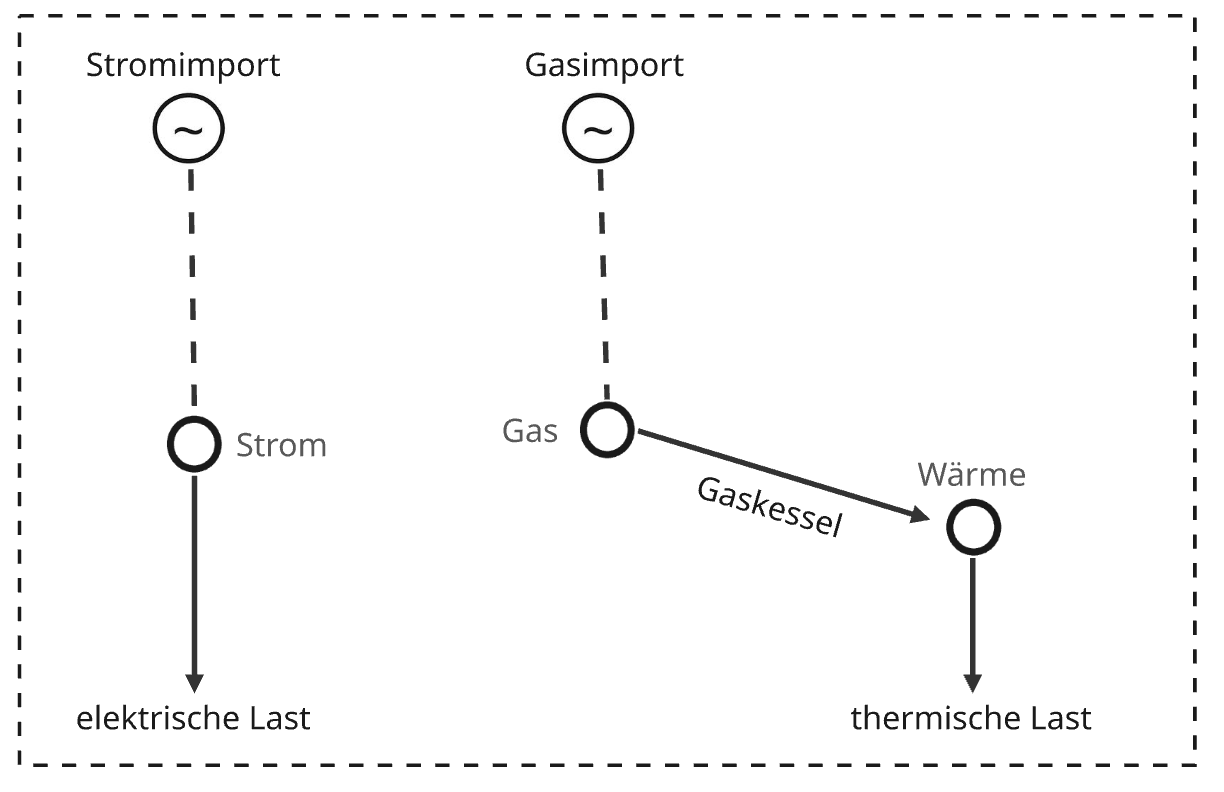

### A.1 Parameter

In [ ]:
# Netzstrom
strom_preis = 0.1361                          # €/kWh
gas_preis = 0.03                            # €/kWh

# Gaskessel
gaskessel_wirkungsgrad = 0.95               # 95%
gas_cost_heat = gas_preis/gaskessel_wirkungsgrad

### A.2 PyPSA-Netzwerk erstellen und optimieren

In [ ]:
network = pypsa.Network()
network.set_snapshots(zeitindex)

# Busse
network.add('Bus', name='Strom', carrier='strom')
network.add('Bus', name='Waerme', carrier='waerme')
network.add('Bus', 'Gas', carrier='gas')

# Lasten
network.add('Load', name='Stromlast', bus='Strom', p_set=strombedarf)
network.add('Load', name='Waermelast', bus='Waerme', p_set=waermebedarf)

# Netzstrom (Import aus öffentlichem Netz)
network.add('Generator',
            name='Stromimport',
            bus='Strom',
            p_nom = np.inf,
            marginal_cost=strom_preis,
            carrier='grid')

# Gasversorgung
network.add('Generator',
            name='Gasimport',
            bus='Gas',
            p_nom = np.inf,
            marginal_cost=gas_preis,
            carrier='gas')

# Gaskessel
network.add("Link",
            name="Gaskessel",
            bus0="Gas",        
            bus1="Waerme",     
            p_nom=waermebedarf.max()/gaskessel_wirkungsgrad,
            efficiency=gaskessel_wirkungsgrad,
            carrier="gas")

# Optimierung
network.optimize(solver_name='gurobi')

### A.3 Ergebnisse – Konventionelles System

In [ ]:
# Nennleistungen
p_nom_gaskessel = waermebedarf.max()/gaskessel_wirkungsgrad
print(f"Nennleistung Gaskessel: {p_nom_gaskessel:>12.2f} kW")

# Strombilanz
print("\n--- Strombilanz ---")
strom_netz = network.generators_t.p['Stromimport'].sum()
strom_last = network.loads_t.p['Stromlast'].sum()
print(f"Netzimport:       {strom_netz:>12.2f} kWh")
print(f"Stromlast:        {strom_last:>12.2f} kWh")

# Wärmebilanz
print("\n--- Wärmebilanz ---")
gas_import = network.generators_t.p['Gasimport'].sum()

waerme_last = network.loads_t.p['Waermelast'].sum()
print(f"Gasimport:    {gas_import:>12.2f} kWh")
print(f"Wärmelast:    {waerme_last:>12.2f} kWh")

# Betriebskosten
print("\n--- Betriebskosten pro Jahr ---")
kosten_strom = strom_netz * strom_preis
kosten_gas = gas_import * gas_cost_heat
operational_costs = round(kosten_strom + kosten_gas, 2)
print(f"Stromkosten:          {kosten_strom:>12.2f} €")
print(f"Gaskosten:            {kosten_gas:>12.2f} €")
print(f"Betriebskosten:       {operational_costs:>12.2f} €")

# **Teil B: Zukunftssystem**

Das **Zukunftssystem** nutzt erneuerbare Energien:

- **Windkraftanlage** zur Stromerzeugung (Nennleistung wird optimiert)
- **Wärmepumpe** zur Umwandlung von Strom in Wärme (zeitabhängiger COP)
- **Stromspeicher** zum Ausgleich der fluktuierenden Windenergie
- **Wärmespeicher** zur zeitlichen Entkopplung von Wärmeproduktion und -bedarf
- **Stromimport** als Backup, wenn Wind + Speicher nicht ausreichen

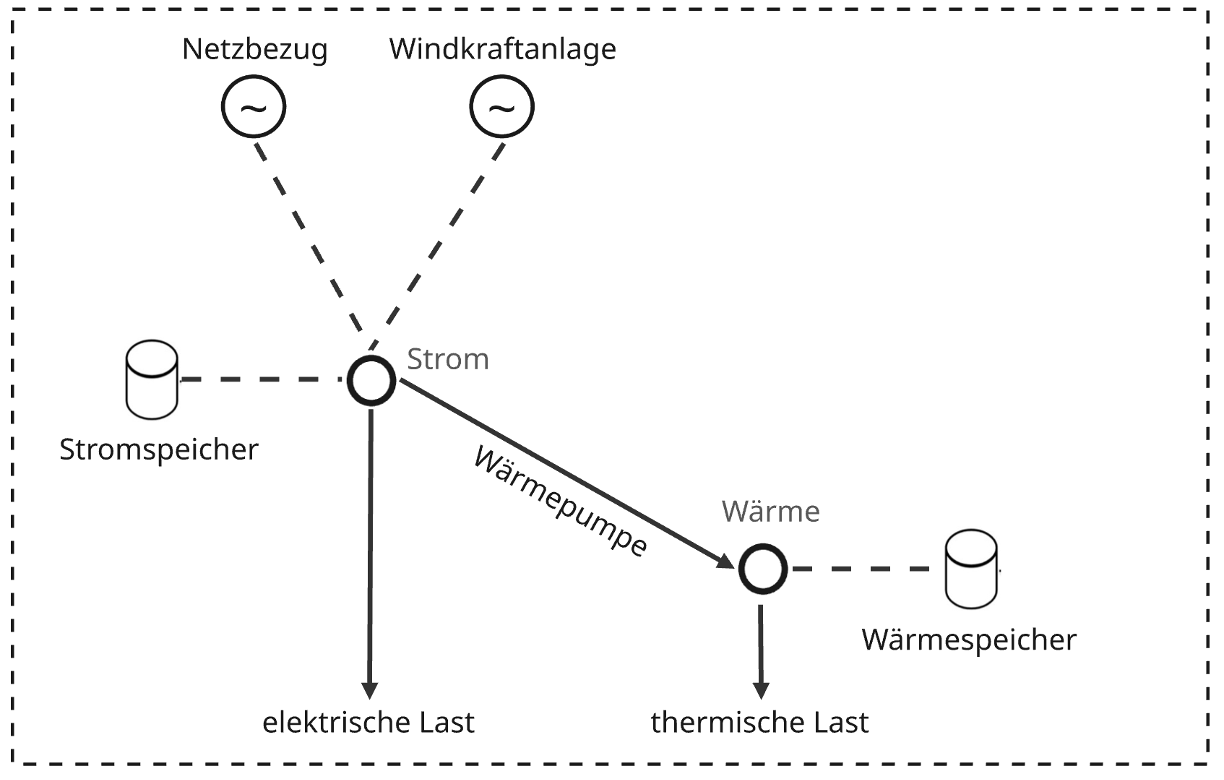

### B.1 Parameter

In [ ]:
# Windkraftanlage
capital_cost_wind = 150                     # €/kW/a als Annuität
wind_lifetime = 20                          # Jahre
wind_nennleistung_vergleichsanlage = 6000   # kW - Nennleistung der Vergleichsanlage

# Stromspeicher
capital_cost_stromspeicher = 45             # €/kWh/a als Annuität
stromspeicher_lifetime = 15
stromspeicher_standing_loss = 0.0001         # Verlust pro Stunde

# Wärmepumpe
capital_cost_wp = 480           # €/kW/a als Annuität
wp_lifetime = 20                # Jahre

# Wärmespeicher
capital_cost_waermespeicher = 5              # €/kWh/a als Annuität
waermespeicher_lifetime = 25                # Jahre
waermespeicher_standing_loss = 0.005         # Verlust pro Stunde

# Stromnetz
netz_import_kosten = 0.1361   # €/kWh

# Zeitliche Verfügbarkeit der Windanlage (p_max_pu)
wind_p_max_pu = windleistung / wind_nennleistung_vergleichsanlage
wind_p_max_pu = wind_p_max_pu.clip(lower=0, upper=1)

### B.2 PyPSA-Netzwerk erstellen und optimieren

Alle Komponenten sind **extendable** – der Optimizer bestimmt die optimale Dimensionierung jeder Komponente, um die Gesamtkosten (Investitions-Annuitäten + Betriebskosten) zu minimieren.

In [ ]:
network_zuk = pypsa.Network()
network_zuk.set_snapshots(zeitindex)

# Busse
network_zuk.add('Bus', name='Strom', carrier='strom')
network_zuk.add('Bus', name='Waerme', carrier='waerme')

# Lasten
network_zuk.add('Load', name='Stromlast', bus='Strom', p_set=strombedarf)
network_zuk.add('Load', name='Waermelast', bus='Waerme', p_set=waermebedarf)

# Windkraftanlage -> Strom-Bus
network_zuk.add('Generator',
            name='Windkraftanlage',
            bus='Strom',
            p_nom_extendable=True,
            p_max_pu=wind_p_max_pu,
            capital_cost=capital_cost_wind,
            lifetime=wind_lifetime,
            carrier='wind')

# Speicher für Windenergie
network_zuk.add('Store',
            name = 'Stromspeicher',
            bus = 'Strom',
            e_nom_extendable = True,
            capital_cost = capital_cost_stromspeicher,
            lifetime= stromspeicher_lifetime,
            standing_loss = stromspeicher_standing_loss ,
            e_cyclic = True)

# Wärmepumpe (Strom -> Wärme) mit zeitabhängigem COP
network_zuk.add('Link',
            name='Waermepumpe',
            bus0='Strom',
            bus1='Waerme',
            efficiency=cop_zeitreihe,
            p_nom_extendable=True,
            capital_cost=capital_cost_wp,
            lifetime=wp_lifetime)

# Wärmespeicher
network_zuk.add('Store',
            name='Waermespeicher',
            bus='Waerme',
            e_nom_extendable=True,
            capital_cost=capital_cost_waermespeicher,
            standing_loss=waermespeicher_standing_loss,
            e_cyclic=True,
            lifetime=waermespeicher_lifetime)

# Stromimport (Backup)
network_zuk.add('Generator',
            name='Netz_Import',
            bus='Strom',
            p_nom_extendable=True,
            marginal_cost=netz_import_kosten,
            carrier='grid')

# Optimierung
network_zuk.optimize(solver_name='gurobi')

### B.3 Ergebnisse – Zukunftssystem

In [ ]:
# Investitionskosten insgesamt 
invest_cost_stromspeicher    = network_zuk.stores.e_nom_opt['Stromspeicher'] * capital_cost_stromspeicher * stromspeicher_lifetime
invest_cost_waermespeicher   = network_zuk.stores.e_nom_opt['Waermespeicher'] * capital_cost_waermespeicher * waermespeicher_lifetime
invest_cost_windkraftanlage  = network_zuk.generators.p_nom_opt['Windkraftanlage'] * capital_cost_wind * wind_lifetime 
invest_cost_waermepumpe      = network_zuk.links.p_nom_opt['Waermepumpe'] * capital_cost_wp * wp_lifetime
invest_cost_gesamt = invest_cost_stromspeicher + invest_cost_waermespeicher + invest_cost_windkraftanlage + invest_cost_waermepumpe 

print("--- Investitionskosten insgesamt ---")
print(f'Stromspeicher:  {invest_cost_stromspeicher:>12.2f} €')
print(f'Wärmespeicher:  {invest_cost_waermespeicher:>12.2f} €')
print(f'Windkraftanlage:{invest_cost_windkraftanlage:>12.2f} €')
print(f'Wärmepumpe:     {invest_cost_waermepumpe:>12.2f} €')
print(f"\nInvestitionskosten insgesamt: {invest_cost_gesamt:.2f} €")

# Investitionskosten pro Jahr
invest_cost_stromspeicher_year    = network_zuk.stores.e_nom_opt['Stromspeicher'] * capital_cost_stromspeicher 
invest_cost_waermespeicher_year   = network_zuk.stores.e_nom_opt['Waermespeicher'] * capital_cost_waermespeicher
invest_cost_windkraftanlage_year  = network_zuk.generators.p_nom_opt['Windkraftanlage'] * capital_cost_wind
invest_cost_waermepumpe_year      = network_zuk.links.p_nom_opt['Waermepumpe'] * capital_cost_wp
invest_cost_year = invest_cost_stromspeicher_year + invest_cost_waermespeicher_year + invest_cost_windkraftanlage_year + invest_cost_waermepumpe_year 

print(f"\n--- Investitionskosten jährlich ---")
print(f'Stromspeicher:  {invest_cost_stromspeicher_year:>12.2f} €')
print(f'Wärmespeicher:  {invest_cost_waermespeicher_year:>12.2f} €')
print(f'Windkraftanlage:{invest_cost_windkraftanlage_year:>12.2f} €')
print(f'Wärmepumpe:     {invest_cost_waermepumpe_year:>12.2f} €')
print(f"\nInvestitionskosten jährlich: {invest_cost_year:.2f} €")

In [ ]:
# Optimierte Leistung
print("--- Optimierte Leistung ---")
wind_opt = network_zuk.generators.p_nom_opt['Windkraftanlage']
print(f"Windanlage:        {wind_opt:>12.2f} kW ")
waermepume_opt = network_zuk.links.p_nom_opt['Waermepumpe']
print(f"Wärmepumpe:        {waermepume_opt:>12.2f} kW")

# Optimierte Speicherkapazität
stormspeicher_opt = network_zuk.stores.e_nom_opt['Stromspeicher']
print(f"Stromspeicher:     {stormspeicher_opt:>12.2f} kWh")
waermespeicher_opt = network_zuk.stores.e_nom_opt['Waermespeicher']
print(f"Wärmespeicher:     {waermespeicher_opt:>12.2f} kWh")

In [ ]:
# Strombilanz
print("--- Strombilanz ---")
strom_wind_gesamt = network_zuk.generators_t.p['Windkraftanlage'].sum()

p_store = network_zuk.stores_t.p["Stromspeicher"]   # kW
energie_in_speicher  = ((-p_store).clip(lower=0)).sum() 

strom_netz_import = network_zuk.generators_t.p['Netz_Import'].sum()
strom_wp = network_zuk.links_t.p0['Waermepumpe'].sum()
strom_last_zuk = network_zuk.loads_t.p['Stromlast'].sum()

print(f"Windkraft gesamt:                   {strom_wind_gesamt:>12.2f} kWh")
print(f'Energie die in den Speicher fließt: {energie_in_speicher:>12.2f} kWh')
print(f"Netz Import:                        {strom_netz_import:>12.2f} kWh")
print(f"Wärmepumpe:                         {strom_wp:>12.2f} kWh")
print(f"Stromlast:                          {strom_last_zuk:>12.2f} kWh")

# Gesamtkosten Gewächshaus für ein Jahr 
print("\n--- Gesamtkosten pro Jahr ---")
kosten_strom_import = strom_netz_import * netz_import_kosten
gesamt_kosten_gewaechshaus = kosten_strom_import + invest_cost_year
print(f"Stromimportkosten:             {kosten_strom_import:>12.2f} €")
print(f"Jährliche Investitionskosten:  {invest_cost_year:>12.2f} €")
print(f"Gesamtkosten pro Jahr:         {gesamt_kosten_gewaechshaus:>12.2f} €")

# Wärmebilanz
print("\n--- Wärmebilanz ---")
waerme_wp = network_zuk.links_t.p1['Waermepumpe'].sum()
waerme_last_zuk = network_zuk.loads_t.p['Waermelast'].sum()
print(f"Wärmepumpe:       {waerme_wp:>12.2f} kWh")
print(f"Wärmelast:        {waerme_last_zuk:>12.2f} kWh")

# Kennzahlen
autakie = strom_wind_gesamt/strom_last_zuk*100

print("\n--- Kennzahlen ---")
print(f"Stromautarkie: {autakie:>12.2f} %")

mittlerer_cop = abs(waerme_wp / strom_wp) if strom_wp > 0 else 0
print(f"Realisierter COP: {mittlerer_cop:>12.2f}")

# Nicht genutzte Windenergie
windenergie_möglich = (network_zuk.generators.p_nom_opt['Windkraftanlage'] * wind_p_max_pu).sum()
windenergie_nicht_genutzt = windenergie_möglich - strom_wind_gesamt
windenergie_genutzt_prozent = (strom_wind_gesamt) / windenergie_möglich * 100

print("\n--- Auslastung der Windkraftanlage ---")
print(f'Nicht genutzte Windenergie: {windenergie_nicht_genutzt:.2f} kWh')
print(f'Nur {windenergie_genutzt_prozent:.2f} % der möglichen Energie der Windkraftanlage wird genutzt')

---
# Teil C: Systemvergleich

In diesem Teil werden die Ergebnisse beider Systeme direkt gegenübergestellt.

In [ ]:
# Variablen Vergleich 
konv_strom_netz = strom_netz
konv_strom_kosten = kosten_strom
konv_gas_kosten = kosten_gas
konv_betriebskosten = operational_costs
konv_gesamt_jahr = operational_costs

zuk_strom_import = strom_netz_import
zuk_kosten_import = kosten_strom_import
zuk_invest_year = invest_cost_year
zuk_betriebskosten = kosten_strom_import
zuk_gesamt_jahr = gesamt_kosten_gewaechshaus

print("=" * 60)
print("SYSTEMVERGLEICH")
print("=" * 60)
print(f"{'':30s} {'Konventionell':>14s} {'Zukunft':>14s}")
print("-" * 60)
print(f"Netzimport [kWh]:              {konv_strom_netz:>14,.0f} {zuk_strom_import:>14,.0f}")
print(f"Stromimportkosten [€/a]:       {konv_strom_kosten:>14,.2f} {zuk_kosten_import:>14,.2f}")
print(f"Gaskosten [€/a]:               {konv_gas_kosten:>14,.2f} {'---':>14s}")
print(f"Betriebskosten [€/a]:          {konv_betriebskosten:>14,.2f} {zuk_betriebskosten:>14,.2f}")
print(f"Investitionskosten [€/a]:      {'---':>14s} {zuk_invest_year:>14,.2f}")
print(f"Gesamtkosten [€/a]:            {konv_gesamt_jahr:>14,.2f} {zuk_gesamt_jahr:>14,.2f}")

einsparung = konv_gesamt_jahr - zuk_gesamt_jahr
print(f"\nEinsparung Zukunft: {einsparung:,.2f} €/Jahr ({einsparung/konv_gesamt_jahr*100:.1f}%)")

---
# Teil D: Vergleichs-Plots

### Plot 1: Netzimport beider Systeme

In [ ]:
# Plot 1: Netzimport

fig, ax = plt.subplots(figsize=(8, 5))
systeme = ['Konventionell', 'Zukunftssystem']
netz_import_werte = [konv_strom_netz, zuk_strom_import]
farben = ['#e74c3c', '#2ecc71']
bars = ax.bar(systeme, netz_import_werte, color=farben, width=0.5)

for bar, val in zip(bars, netz_import_werte):
    # Einfache Formatierung ohne spezielle Lokalisierung
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50000,
            f'{val:,.0f} kWh', ha='center', fontsize=11, fontweight='bold')

ax.set_ylabel('Netzimport [kWh/Jahr]')
ax.set_title('Netzimport – Konventionell vs. Zukunftssystem')
ax.set_ylim(0, max(netz_import_werte) * 1.15)

# Standard-Formatierung für Y-Achse
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

### Plot 2: Stromimportkosten beider Systeme

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
strom_kosten_werte = [konv_strom_kosten, zuk_kosten_import]
bars = ax.bar(systeme, strom_kosten_werte, color=farben, width=0.5)
for bar, val in zip(bars, strom_kosten_werte):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000,
            f'{val:,.0f} €', ha='center', fontsize=11, fontweight='bold')
ax.set_ylabel('Stromimportkosten [€/Jahr]')
ax.set_title('Stromimportkosten – Konventionell vs. Zukunftssystem')
ax.set_ylim(0, max(strom_kosten_werte) * 1.15)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

### Plot 3: Windenergie-Erzeugung über das Jahr

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
wind_erzeugung = network_zuk.generators_t.p['Windkraftanlage']
ax.plot(wind_erzeugung.index, wind_erzeugung.values, color='#3498db', alpha=0.7, linewidth=0.5, label='Windkraft-Erzeugung')
ax.set_ylabel('Leistung [kW]')
ax.set_xlabel('Zeit')
ax.set_title('Windkraftanlage – Erzeugte Leistung über das Jahr')
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.tight_layout()
plt.show()

### Plot 4: Windproduktion vs. Gewächshaus-Verbrauch

Tagesmittelwerte – grüne Flächen zeigen Zeiträume, in denen die Windkraft den gesamten Verbrauch deckt. Rote Flächen zeigen Defizite, die durch Netzimport gedeckt werden müssen.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
wind_daily = wind_erzeugung.resample('D').mean()
verbrauch_daily = (strombedarf + network_zuk.links_t.p0['Waermepumpe']).resample('D').mean()

ax.plot(wind_daily.index, wind_daily.values, color='#3498db', linewidth=1.5, label='Windkraft-Erzeugung')
ax.plot(verbrauch_daily.index, verbrauch_daily.values, color='#e74c3c', linewidth=1.5, label='Gesamtverbrauch (Strom + WP)')
ax.fill_between(wind_daily.index, wind_daily.values, verbrauch_daily.values,
                where=wind_daily.values > verbrauch_daily.values, alpha=0.3, color='green',
                label='Wind > Verbrauch')
ax.fill_between(wind_daily.index, wind_daily.values, verbrauch_daily.values,
                where=wind_daily.values < verbrauch_daily.values, alpha=0.3, color='red',
                label='Verbrauch > Wind (Netzimport)')
ax.set_ylabel('Leistung [kW] (Tagesmittel)')
ax.set_xlabel('Zeit')
ax.set_title('Windproduktion vs. Gewächshaus-Verbrauch (Tagesmittel)')
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.tight_layout()
plt.show()

### Plot 5: Speicher-Füllstände über das Jahr

Oben: Stromspeicher, Unten: Wärmespeicher

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

strom_speicher = network_zuk.stores_t.e['Stromspeicher']
axes[0].plot(strom_speicher.index, strom_speicher.values, color='#3498db', linewidth=0.8)
axes[0].set_ylabel('Energie [kWh]')
axes[0].set_title('Stromspeicher – Füllstand über das Jahr')

waerme_speicher = network_zuk.stores_t.e['Waermespeicher']
axes[1].plot(waerme_speicher.index, waerme_speicher.values, color='#e74c3c', linewidth=0.8)
axes[1].set_ylabel('Energie [kWh]')
axes[1].set_xlabel('Zeit')
axes[1].set_title('Wärmespeicher – Füllstand über das Jahr')

for a in axes:
    a.xaxis.set_major_locator(mdates.MonthLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

### Plot 6: Jährliche Gesamtkosten – Gestapelter Vergleich

Konventionell: Nur Betriebskosten (Strom + Gas).  
Zukunftssystem: Stromimportkosten + Investitionskosten (Annuität).

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
breite = 0.5

# Konventionell: Strom + Gas (keine Invest)
konv_stack = [konv_strom_kosten, konv_gas_kosten, 0]

# Zukunft: Stromimport + Invest
zuk_stack = [zuk_kosten_import, 0, zuk_invest_year]

p1 = ax.bar(x, [konv_stack[0], zuk_stack[0]], breite, color='#e74c3c', label='Stromkosten')
p2 = ax.bar(x, [konv_stack[1], zuk_stack[1]], breite,
            bottom=[konv_stack[0], zuk_stack[0]],
            color='#f39c12', label='Gaskosten')
p3 = ax.bar(x, [konv_stack[2], zuk_stack[2]], breite,
            bottom=[konv_stack[0]+konv_stack[1], zuk_stack[0]+zuk_stack[1]],
            color='#3498db', label='Investitionskosten (Annuität)')

# Gesamtwerte oben anzeigen
for i, total in enumerate([konv_gesamt_jahr, zuk_gesamt_jahr]):
    ax.text(i, total + 20000, f'{total:,.0f} €', ha='center', fontsize=11, fontweight='bold')

# Einheitliche Skala
max_kosten = max(konv_gesamt_jahr, zuk_gesamt_jahr)
ax.set_ylim(0, max_kosten * 1.2)

ax.set_xticks(x)
ax.set_xticklabels(['Konventionell', 'Zukunftssystem'])
ax.set_ylabel('Kosten [€/Jahr]')
ax.set_title('Jährliche Gesamtkosten – Vergleich beider Systeme')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=4)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()